In [1]:
from utils import *
import pickle
import time
import scipy
import itertools
from scipy.optimize import minimize
from experiment import DR_Markowitz_Experiment
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
class Configuration:
    """
    Class that saves the value of Default Parameters
    """
    learning_rate = 0.01
    max_iter = 50000
    tol = 0
    model_name = "Default Model"
    fit_intercept = True
    regularization = 0.1 # Regularization parameter
    delta = 0.1
    gamma = 0
    A = 1

In [3]:
class GradientDescent(object):
    """
    Abstract Model for Gradient Descent
    ================
    Member Variables
    ================
    learning_rate (float) : Learning rate for gradient descent algorithm.
    max_iter      (int)   : Max num of iteration of gradient descent method.
    total_iter    (int)   : Total num of iteration in training.
    tol           (float) : If the change in the loss function <= tol in the
                            last 100 iterations, early terminate the model.
    var        np.array[dim]       : Initialization of the variables of the
                                     optimization problem.
    dim        int                 : Dimension of the variable
    loss_path  np.array[max_iter]  : Path of the loss function during gradient
                                     descent.
    var_path   np.ndarray[max_iter,dim]: Path of the variable during training
    """

    def __init__(self, **kwargs):
        # Initialization using the default configuration
        self.learning_rate = Configuration.learning_rate
        self.max_iter = Configuration.max_iter
        self.total_iter = Configuration.max_iter
        self.tol = Configuration.tol
        self.model_name = Configuration.model_name

        # Initialization using user input value from **kwargs
        for key in kwargs:
            if key in self.__dict__:
                self.__dict__[key] = kwargs[key]
            else:
                raise AttributeError("Unknown Initialization of {}"
                                     .format(key))
        # Check Initialization of variable var
        if "var" not in self.__dict__:
            raise NotImplementedError("var is not initialized")
        if type(self.var) is not np.ndarray or self.var.ndim > 1:
            raise TypeError("var should be 1-dim np.ndarray")
        
        self.dim = self.var.size
        self.loss_path = np.zeros(self.max_iter, dtype=float)
        self.var_path = np.zeros((self.max_iter, self.dim), dtype=float)

    def gradient(self, method = "analytic"):
        """
        Compute the Gradient for the Model
        """
        if method is "analytic":
            return self._analytical_gradient()
        elif method is "numeric":
            return eval_numerical_gradient(self.loss, self.var)
        if method is "stochastic":
            return self._stochastic_gradient()
        else:
            raise ValueError("Unknown Method to Compute Gradient: {}"
                             .format(method))
    def _analytical_gradient(self):
        """
        Compute the Analytical Gradient for the Model
        """
        raise NotImplementedError("""Analytical gradient is not implemented. 
        Please use numerical gradient instead.""")
        
    def _stochastic_gradient(self):
        """
        Compute the Stochastic Gradient for the Model
        """
        raise NotImplementedError("""Stochastic gradient is not implemented. 
        Please use numerical gradient instead.""")
    
    def loss(self):
        """
        Loss Functiton for the Model
        """
        raise NotImplementedError("""Loss is not implemented.""")

    def project(self):
        """
        Compute the Projection for Projected Gradient Descent Method
        """
        pass

    def optimize(self, verbose=False, grad_method='analytic'):
        """
        Run the Gradient Descent Algorithm for the model
        """
        for iter_ in range(self.max_iter):
            gradient = self.gradient(method=grad_method)
            self.var -= self.learning_rate * gradient / np.sqrt(1+iter_)
            self.project()
            loss = self.loss()
            self.loss_path[iter_] = loss
            self.var_path[iter_, :] = self.var
            if 'min_lambda_path' in dir(self):
                self.min_lambda_path[iter_] = self.min_lambda
                
            if verbose and iter_ % 1 == 0:
                print("Step:{}\tLoss = {}".format(iter_, loss))
                print("Var:\n{}".format(self.var))
                if 'min_lambda' in dir(self):
                    print("Min Lambda:\n{}".format(self.min_lambda))
                print("Gradient:\n{}".format(gradient))

    def plot_loss_path(self):
        """
        Plot the loss path of the model after training
        """
        x = range(1, self.total_iter + 1)
        plt.loglog(x, self.loss_path[:self.total_iter])
        plt.title(self.model_name)
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.show()

In [4]:
class LinearRegressionGradientDescent(GradientDescent):
    """
    Gradient Descent for Linear Regression Model (No intercept)
    ================
    Member Variables
    ================
    learning_rate (float) : Learning rate for gradient descent algorithm.
    max_iter      (int)   : Max num of iteration of gradient descent method.
    tol           (float) : If the change in the loss function <= tol in the
                            last 100 iterations, early terminate the model.
    X       np.ndarray[num_train,dim]:training data for linear regression model.
    y       np.array[num_train]    : The response vec for training.
    var        np.array[dim]       : Initialization of the variables of the
                                     optimization problem.
    dim        int                 : Dimension of the variable
    loss_path  np.array[max_iter]  : Path of the loss function during gradient
                                     descent.
    var_path   np.ndarray[max_iter,dim]: Path of the variable during training
    """

    def __init__(self, X, y, **kwargs):
        self.X = np.array(X)
        self.y = np.array(y)
        self.var = np.zeros(X.shape[1])
        super().__init__(**kwargs)
        # Check the dim of the data
        assert(self.X.shape[0] == self.y.size)
        assert(self.X.shape[1] == self.var.size)
        
    def _analytical_gradient(self):
        """
        Compute the Analytical Gradient for the Model
        """
        return np.mean(2 * (self.X.dot(self.var) - self.y) * self.X.T, axis=1)

    def loss(self, var=None):
        """
        Loss Function for Linear Regression Model
        Compute the Mean Squared Error for Linear Regression
        If var is None, compute loss at self.var
        Otherwise compute loss at var
        """
        if var is None:
            var = self.var
        return np.square(self.X.dot(var) - self.y).mean()

    def project(self):
        """
        No Projection for LR
        """
        pass

In [5]:
class DistRobustLinearRegression(GradientDescent):
    """
    Abstract Model for Gradient Descent
    ================
    Member Variables
    ================
    learning_rate (float) : Learning rate for gradient descent algorithm.
    max_iter      (int)   : Max num of iteration of gradient descent method.
    tol           (float) : If the change in the loss function <= tol in the
                            last 100 iterations, early terminate the model.
    var        np.ndarray[dim]     : Initialization of the variables of the
                                     optimization problem.
                                     The last dim represents the lagrange multiplier
                                     lambda
    X          np.ndarray          : Training data
                                     X[num_train, dim - 1] if fit_intercept = False
                                     X[num_train, dim - 2] if fit_intercept = True
    dim        int                 : Dimension of the variable (including lambda)
    A          np.ndarray: The local Mahalanobis matrice for DRO
    ------------------------------------------------------------------------------
    If A == None    ========>> A = 1, no Mahalanobis distance, using squared 
                                 Euclidean distance.
    If A.ndim == 2  ========>> A[dim-1, dim-1] Mahalanobis distance if fit_intercept = False
                               A[dim-2, dim-2] if fit_intercept = True
    If A.ndim == 3  ========>> A[dim-1, dim-1, num_train] if fit_intercept = False
                               A[dim-2, dim-2, num_train] if fit_intercept = True
                               where A[:,:,i] is the local Mahalanobis matrix
                               that corresponds to the ith data point.
    ------------------------------------------------------------------------------
    delta      float               : The size of distributional uncertainty set
    gamma      float               : The parameter used in the inner_max problem
    
    loss_path  np.ndarray[max_iter]: Path of the loss function during gradient
                                     descent.
    var_path   np.ndarray[max_iter,dim]: Path of the variable during training
    """
    
    def __init__(self, X, y = None, **kwargs):
        # Subclass of DistRobustGradientDescent should initialize var
        # in their __init__.
        self.X = np.array(X)
        self.num_train = X.shape[0]
        self.y = np.zeros(self.num_train) if y is None else np.array(y)
        self.fit_intercept = Configuration.fit_intercept
        self.delta = Configuration.delta
        self.gamma = Configuration.gamma
        self.A = np.array(Configuration.A)
        self.vardim = X.shape[1] + 1 + self.fit_intercept
        self.var = np.zeros(self.vardim)
        self.var[-1] = 5
        super().__init__(**kwargs)
        
        self.lambda_ = self.var[-1:]
        if self.fit_intercept:
            self.beta = self.var[:-2]
            self.intercept = self.var[-2:-1]
        else:
            self.beta = self.var[:-1]
            self.intercept = 0
        
        self._check_dimension()
        
        # Computation of invA
        if self.A.ndim == 0:
            arrays = [np.eye(X.shape[1]) / self.A  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 2:
            arrays = [np.linalg.inv(self.A)  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 3:
            self.invA = np.zeros_like(self.A)
            for i in range(self.A.shape[2]):
                self.invA[:, :, i] = np.linalg.inv(self.A[:, :, i])
    
    def l_func(self, x):
        """
        The l function that maps from R to R.
        The nonrobust loss is l(beta.T * x)
        """
        return np.square(x)
    
    def non_robust_loss(self, var=None):
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        return self.l_func(self.X.dot(beta) + intercept)
        
    def loss(self, var=None):
        """
        The robustified loss function for distributionally robust optimization
        """
        # Unpack Parameters
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        # Ancillary Variable: anc1 = sqrt(delta) * beta^T * inv(A) * beta
        transport_X = self.transport_X(var = var)
        opt_gamma = self.opt_gamma(var = var)
        loss = np.mean(self.l_func(transport_X.dot(beta) + intercept - self.y)) \
        - lambda_ * np.sqrt(self.delta) * (np.mean(np.square(opt_gamma) * beta.dot(beta.dot(self.invA))) - 1)
        return loss
    
    def opt_gamma(self, var=None):
        # Unpack Parameters
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))
        return (self.X.dot(beta) + intercept - self.y) / (lambda_ - anc1)
    
    def transport_X(self, var=None):
        # Unpack Parameters
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        opt_gamma = self.opt_gamma(var)
        res = self.X + np.transpose(np.sqrt(self.delta) * opt_gamma * beta.dot(self.invA))
        return res
        
    def _analytical_gradient(self):
        var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        transport_X = self.transport_X()
        opt_gamma = self.opt_gamma()
        grad_beta = 2 * np.transpose((transport_X.dot(beta) + intercept - self.y) * transport_X.T)
        grad_lambda = -np.sqrt(self.delta) * (np.square(opt_gamma)*beta.dot(beta.dot(self.invA)) - 1)
        if self.fit_intercept:
            grad_intercept = 2 * (transport_X.dot(beta) + intercept - self.y)
            return np.append(np.mean(grad_beta, axis = 0), [np.mean(grad_intercept), np.mean(grad_lambda)])
        else:
            return np.append(np.mean(grad_beta, axis = 0), np.mean(grad_lambda))
        
    def _stochastic_gradient(self):
        var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        transport_X = self.transport_X()
        opt_gamma = self.opt_gamma()
        grad_beta = 2 * np.transpose((transport_X.dot(beta) + intercept - self.y) * transport_X.T)
        grad_lambda = -np.sqrt(self.delta) * (np.square(opt_gamma)*beta.dot(beta.dot(self.invA)) - 1)
        rand_i = np.random.randint(self.num_train)
        if self.fit_intercept:
            grad_intercept = 2 * (transport_X.dot(beta) + intercept - self.y)
            return np.append(grad_beta[rand_i], [grad_intercept[rand_i], grad_lambda[rand_i]])
        else:
            return np.append(grad_beta[rand_i], grad_lambda[rand_i])
        
    def project(self):
        pass
    
    def plot_lambda_path(self):
        """
        Plot the path of lambda
        """
        x = range(1, self.total_iter + 1)
        plt.plot(x, self.var_path[:self.total_iter, -1])
        plt.title(self.model_name)
        plt.xlabel('Steps')
        plt.ylabel('Lambda')
        plt.show()
        
    def optimize(self, verbose=False, grad_method='stochastic', loss_path_idx = None):
        """
        Run the Gradient Descent Algorithm for the model
        """
        self.loss_path = {}
        for iter_ in range(self.max_iter):
            gradient = self.gradient(method=grad_method)
            self.var -= (self.learning_rate * gradient / (1+iter_) ** 0.5)
            self.project()
            if iter_ in loss_path_idx:
                loss = self.loss()
                self.loss_path[iter_] = self.loss()
                
            if verbose and iter_ % 1 == 0:
                print("Step:{}\tLoss = {}".format(iter_, loss))
                print("Var:\n{}".format(self.var))
                if 'min_lambda' in dir(self):
                    print("Min Lambda:\n{}".format(self.min_lambda))
                print("Gradient:\n{}".format(gradient))
        
    def _check_dimension(self):
        # Check Dimension:
        if self.A.ndim not in (0,2,3):
            raise ValueError("The dimension of A should be 0, 2 or 3.")
        if self.X.ndim != 2:
            raise ValueError("The input data X should be a matrix")
        beta_dim = self.dim - 2 if self.fit_intercept else self.dim - 1
        
        if self.A.ndim in (2,3):
            assert(beta_dim == self.A.shape[0] == self.A.shape[1] == self.X.shape[1])
        if self.A.ndim is 3:
            assert(self.train_num == self.A.shape[2])

In [6]:
class DistRobustLogisticRegression(GradientDescent):
    """
    Abstract Model for Gradient Descent
    ================
    Member Variables
    ================
    learning_rate (float) : Learning rate for gradient descent algorithm.
    max_iter      (int)   : Max num of iteration of gradient descent method.
    tol           (float) : If the change in the loss function <= tol in the
                            last 100 iterations, early terminate the model.
    var        np.ndarray[dim]     : Initialization of the variables of the
                                     optimization problem.
                                     The last dim represents the lagrange multiplier
                                     lambda
    X          np.ndarray          : Training data
                                     X[num_train, dim - 1] if fit_intercept = False
                                     X[num_train, dim - 2] if fit_intercept = True
    dim        int                 : Dimension of the variable (including lambda)
    A          np.ndarray: The local Mahalanobis matrice for DRO
    ------------------------------------------------------------------------------
    If A == None    ========>> A = 1, no Mahalanobis distance, using squared 
                                 Euclidean distance.
    If A.ndim == 2  ========>> A[dim-1, dim-1] Mahalanobis distance if fit_intercept = False
                               A[dim-2, dim-2] if fit_intercept = True
    If A.ndim == 3  ========>> A[dim-1, dim-1, num_train] if fit_intercept = False
                               A[dim-2, dim-2, num_train] if fit_intercept = True
                               where A[:,:,i] is the local Mahalanobis matrix
                               that corresponds to the ith data point.
    ------------------------------------------------------------------------------
    delta      float               : The size of distributional uncertainty set
    gamma      float               : The parameter used in the inner_max problem
    
    loss_path  np.ndarray[max_iter]: Path of the loss function during gradient
                                     descent.
    var_path   np.ndarray[max_iter,dim]: Path of the variable during training
    """
    
    def __init__(self, X, y = None, **kwargs):
        # Subclass of DistRobustGradientDescent should initialize var
        # in their __init__.
        self.X = np.array(X)
        self.num_train = X.shape[0]
        self.y = np.zeros(self.num_train) if y is None else np.array(y)
        self.fit_intercept = Configuration.fit_intercept
        self.delta = Configuration.delta
        self.gamma = Configuration.gamma
        self.A = np.array(Configuration.A)
        self.vardim = X.shape[1] + 1 + self.fit_intercept
        self.var = np.zeros(self.vardim)
        self.var[-1] = 1
        super().__init__(**kwargs)
        
        self.lambda_ = self.var[-1:]
        if self.fit_intercept:
            self.beta = self.var[:-2]
            self.intercept = self.var[-2:-1]
        else:
            self.beta = self.var[:-1]
            self.intercept = 0
        
        self._check_dimension()
        
        # Computation of invA
        if self.A.ndim == 0:
            arrays = [np.eye(X.shape[1]) / self.A  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 2:
            arrays = [np.linalg.inv(self.A)  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 3:
            self.invA = np.zeros_like(self.A)
            for i in range(self.A.shape[2]):
                self.invA[:, :, i] = np.linalg.inv(self.A[:, :, i])
    
    def l_func(self, x):
        """
        The l function that maps from R to R.
        The nonrobust loss is l(beta.T * x)
        """
        return np.log(1 + np.exp(-x))
    
    def non_robust_loss(self, var=None):
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        return np.mean(self.l_func(self.y * (self.X.dot(beta) + intercept)))
        
    def loss(self, var=None):
        """
        The robustified loss function for distributionally robust optimization
        """
        # Unpack Parameters
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        # Ancillary Variable: anc1 = sqrt(delta) * beta^T * inv(A) * beta
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))        
        opt_gamma = np.zeros(self.num_train)
        opt_val = np.zeros(self.num_train)
        
        for data_id in range(self.num_train):
            obj = lambda gamma: -self.l_func(self.y[data_id] * (self.X[data_id,:].dot(beta) + intercept \
                                            + gamma*anc1[data_id])) \
            + lambda_*np.square(gamma)*anc1[data_id] - lambda_*np.sqrt(self.delta)
            res = minimize(obj, 0)
            opt_gamma[data_id] = res.x
            opt_val[data_id] = -res.fun
        
        return opt_val.mean()
    
    def _analytical_gradient(self):
        pass
    
    def _stochastic_gradient(self):
        var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        
        rand_i = np.random.randint(self.num_train)
        
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))      
        obj = lambda gamma: -self.l_func(self.y[rand_i] * (self.X[rand_i,:].dot(beta) + intercept \
                                            + gamma*anc1[rand_i])) \
            + lambda_*np.square(gamma)*anc1[rand_i] - lambda_*np.sqrt(self.delta)
        res = minimize(obj, 0)
        
        opt_gamma = res.x
        opt_val = -res.fun
        
        transport_X = self.X[rand_i,:] + np.transpose(np.sqrt(self.delta) * opt_gamma * beta.dot(self.invA[:,:,rand_i]))
        y = self.y[rand_i]
        
        grad_beta = np.transpose(transport_X*(- y)) / (1+np.exp(y * (transport_X.dot(beta) + intercept)))
        grad_lambda = -np.sqrt(self.delta) * (np.square(opt_gamma)*beta.dot(beta.dot(self.invA[:,:,rand_i])) - 1)
        
        if self.fit_intercept:
            grad_intercept = -y / (1+np.exp(y * (transport_X.dot(beta) + intercept)))
            return np.array(np.append(grad_beta, [grad_intercept, grad_lambda]))
        else:
            return np.array(np.append(grad_beta, grad_lambda))
    
    def project(self):
        pass
    
    def compute_transport_X(self):
        self._optimize_lambda()
        var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))        
        opt_gamma = np.zeros(self.num_train)
        transport_X = 0 * self.X
        
        for data_id in range(self.num_train):
            obj = lambda gamma: -self.l_func(self.y[data_id] * (self.X[data_id,:].dot(beta) + intercept \
                                            + gamma*anc1[data_id])) \
            + lambda_*np.square(gamma)*anc1[data_id] - lambda_*np.sqrt(self.delta)
            res = minimize(obj, 0)
            opt_gamma[data_id] = res.x
            transport_X[data_id,:] = self.X[data_id,:] + np.transpose(
                np.sqrt(self.delta) * opt_gamma[data_id] * beta.dot(self.invA[:,:,data_id]))
        return transport_X
        
    def _optimize_lambda(self):
        for iter_ in range(4000):
            gradient = self.gradient(method='stochastic')
            self.var[-1:] -= (0.005 * gradient[-1:])
            
    def optimize(self, verbose=False, grad_method='stochastic', loss_path_idx = None):
        """
        Run the Gradient Descent Algorithm for the model
        """
        self.loss_path = {}
        for iter_ in range(self.max_iter):
            gradient = self.gradient(method=grad_method)
            self.var -= (self.learning_rate * gradient / (1+iter_) ** 0.6)
            self.project()
            if iter_ in loss_path_idx:
                loss = self.loss()
                self.loss_path[iter_] = self.loss()
                
            if verbose and iter_ % 1 == 0:
                print("Step:{}\tLoss = {}".format(iter_, loss))
                print("Var:\n{}".format(self.var))
                if 'min_lambda' in dir(self):
                    print("Min Lambda:\n{}".format(self.min_lambda))
                print("Gradient:\n{}".format(gradient))
    
    def plot_lambda_path(self):
        """
        Plot the path of lambda
        """
        x = range(1, self.total_iter + 1)
        plt.plot(x, self.var_path[:self.total_iter, -1])
        plt.title(self.model_name)
        plt.xlabel('Steps')
        plt.ylabel('Lambda')
        plt.show()
    
    def _check_dimension(self):
        # Check Dimension:
        if self.A.ndim not in (0,2,3):
            raise ValueError("The dimension of A should be 0, 2 or 3.")
        if self.X.ndim != 2:
            raise ValueError("The input data X should be a matrix")
        beta_dim = self.dim - 2 if self.fit_intercept else self.dim - 1
        
        if self.A.ndim in (2,3):
            assert(beta_dim == self.A.shape[0] == self.A.shape[1] == self.X.shape[1])
        if self.A.ndim is 3:
            assert(self.train_num == self.A.shape[2])

In [7]:
class DistRobustSVM(GradientDescent):
    """
    Abstract Model for Gradient Descent
    ================
    Member Variables
    ================
    learning_rate (float) : Learning rate for gradient descent algorithm.
    max_iter      (int)   : Max num of iteration of gradient descent method.
    tol           (float) : If the change in the loss function <= tol in the
                            last 100 iterations, early terminate the model.
    var        np.ndarray[dim]     : Initialization of the variables of the
                                     optimization problem.
                                     The last dim represents the lagrange multiplier
                                     lambda
    X          np.ndarray          : Training data
                                     X[num_train, dim - 1] if fit_intercept = False
                                     X[num_train, dim - 2] if fit_intercept = True
    dim        int                 : Dimension of the variable (including lambda)
    A          np.ndarray: The local Mahalanobis matrice for DRO
    ------------------------------------------------------------------------------
    If A == None    ========>> A = 1, no Mahalanobis distance, using squared 
                                 Euclidean distance.
    If A.ndim == 2  ========>> A[dim-1, dim-1] Mahalanobis distance if fit_intercept = False
                               A[dim-2, dim-2] if fit_intercept = True
    If A.ndim == 3  ========>> A[dim-1, dim-1, num_train] if fit_intercept = False
                               A[dim-2, dim-2, num_train] if fit_intercept = True
                               where A[:,:,i] is the local Mahalanobis matrix
                               that corresponds to the ith data point.
    ------------------------------------------------------------------------------
    delta      float               : The size of distributional uncertainty set
    gamma      float               : The parameter used in the inner_max problem
    
    loss_path  np.ndarray[max_iter]: Path of the loss function during gradient
                                     descent.
    var_path   np.ndarray[max_iter,dim]: Path of the variable during training
    """
    
    def __init__(self, X, y = None, **kwargs):
        # Subclass of DistRobustGradientDescent should initialize var
        # in their __init__.
        self.X = np.array(X)
        self.num_train = X.shape[0]
        self.y = np.zeros(self.num_train) if y is None else np.array(y)
        self.fit_intercept = Configuration.fit_intercept
        self.delta = Configuration.delta
        self.gamma = Configuration.gamma
        self.A = np.array(Configuration.A)
        self.vardim = X.shape[1] + 1 + self.fit_intercept
        self.var = np.zeros(self.vardim)
        self.var[-1] = 1
        super().__init__(**kwargs)
        
        self.lambda_ = self.var[-1:]
        if self.fit_intercept:
            self.beta = self.var[:-2]
            self.intercept = self.var[-2:-1]
        else:
            self.beta = self.var[:-1]
            self.intercept = 0
        
        self._check_dimension()
        
        # Computation of invA
        if self.A.ndim == 0:
            arrays = [np.eye(X.shape[1]) / self.A  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 2:
            arrays = [np.linalg.inv(self.A)  for _ in range(self.num_train)]
            self.invA = np.stack(arrays, axis = 2)
        elif self.A.ndim == 3:
            self.invA = np.zeros_like(self.A)
            for i in range(self.A.shape[2]):
                self.invA[:, :, i] = np.linalg.inv(self.A[:, :, i])
    
    def l_func(self, x):
        """
        The l function that maps from R to R.
        The nonrobust loss is l(beta.T * x)
        """
        return np.max(1-x)
    
    def non_robust_loss(self, var=None):
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        return np.mean(self.l_func(self.y * (self.X.dot(beta) + intercept)))
        
    def loss(self, var=None):
        """
        The robustified loss function for distributionally robust optimization
        """
        # Unpack Parameters
        if var is None:
            var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        else:
            if self.fit_intercept:
                beta, intercept, lambda_ = var[:-2], var[-2:-1], var[-1:]
            else:
                beta, intercept, lambda_ = var[:-1], 0, var[-1:]
        # Ancillary Variable: anc1 = sqrt(delta) * beta^T * inv(A) * beta
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))        
        opt_gamma = np.zeros(self.num_train)
        opt_val = np.zeros(self.num_train)
        
        for data_id in range(self.num_train):
            obj = lambda gamma: -self.l_func(self.y[data_id] * (self.X[data_id,:].dot(beta) + intercept \
                                            + gamma*anc1[data_id])) \
            + lambda_*np.square(gamma)*anc1[data_id] - lambda_*np.sqrt(self.delta)
            res = minimize(obj, 0)
            opt_gamma[data_id] = res.x
            opt_val[data_id] = -res.fun
        
        return opt_val.mean()
        
    def _analytical_gradient(self):
        pass
    
    def _stochastic_gradient(self):
        var, beta, intercept, lambda_ = self.var, self.beta, self.intercept, self.lambda_
        
        rand_i = np.random.randint(self.num_train)
        
        anc1 = np.sqrt(self.delta) * beta.dot(beta.dot(self.invA))      
        obj = lambda gamma: -self.l_func(self.y[rand_i] * (self.X[rand_i,:].dot(beta) + intercept \
                                            + gamma*anc1[rand_i])) \
            + lambda_*np.square(gamma)*anc1[rand_i] - lambda_*np.sqrt(self.delta)
        res = minimize(obj, 0)
        
        opt_gamma = res.x
        opt_val = -res.fun
        
        transport_X = self.X[rand_i,:] + np.transpose(np.sqrt(self.delta) * opt_gamma * beta.dot(self.invA[:,:,rand_i]))
        y = self.y[rand_i]
        
        grad_beta = np.transpose(transport_X*(- y)) * (y * (transport_X.dot(beta) + intercept) < 1)
        grad_lambda = -np.sqrt(self.delta) * (np.square(opt_gamma)*beta.dot(beta.dot(self.invA[:,:,rand_i])) - 1)
        if self.fit_intercept:
            grad_intercept = -y * (y * (transport_X.dot(beta) + intercept) < 1)
            
            return np.array(np.append(grad_beta, [grad_intercept, grad_lambda]))
        else:
            return np.array(np.append(grad_beta, grad_lambda))
    
    def project(self):
        pass
    
    def optimize(self, verbose=False, grad_method='stochastic', loss_path_idx = None):
        """
        Run the Gradient Descent Algorithm for the model
        """
        self.loss_path = {}
        for iter_ in range(self.max_iter):
            gradient = self.gradient(method=grad_method)
            self.var -= (self.learning_rate * gradient / (1+iter_) ** 0.5)
            self.project()
            if iter_ in loss_path_idx:
                loss = self.loss()
                self.loss_path[iter_] = self.loss()
                
            if verbose and iter_ % 1 == 0:
                print("Step:{}\tLoss = {}".format(iter_, loss))
                print("Var:\n{}".format(self.var))
                if 'min_lambda' in dir(self):
                    print("Min Lambda:\n{}".format(self.min_lambda))
                print("Gradient:\n{}".format(gradient))
    
    def plot_lambda_path(self):
        """
        Plot the path of lambda
        """
        x = range(1, self.total_iter + 1)
        plt.plot(x, self.var_path[:self.total_iter, -1])
        plt.title(self.model_name)
        plt.xlabel('Steps')
        plt.ylabel('Lambda')
        plt.show()
    
    def _check_dimension(self):
        # Check Dimension:
        if self.A.ndim not in (0,2,3):
            raise ValueError("The dimension of A should be 0, 2 or 3.")
        if self.X.ndim != 2:
            raise ValueError("The input data X should be a matrix")
        beta_dim = self.dim - 2 if self.fit_intercept else self.dim - 1
        
        if self.A.ndim in (2,3):
            assert(beta_dim == self.A.shape[0] == self.A.shape[1] == self.X.shape[1])
        if self.A.ndim is 3:
            assert(self.train_num == self.A.shape[2])

In [45]:
true_var = np.random.randn(16)
X, y = LinearRegressionDataGenerator(true_var).generate(256)
loss_path_idx = list(range(10))+ list(range(10,100,10)) + \
list(range(100,2001,50)) + list(range(3000,10001,1000)) + [20000]
my_DR_LR_model_delta_0 = DistRobustLinearRegression(X=X, y=y)
my_DR_LR_model_delta_0.delta = 0.0
my_DR_LR_model_delta_0.optimize(loss_path_idx = loss_path_idx)
my_DR_LR_model_delta_01 = DistRobustLinearRegression(X=X, y=y)
my_DR_LR_model_delta_01.delta = 0.1
my_DR_LR_model_delta_01.optimize(loss_path_idx = loss_path_idx)
my_DR_LR_model_delta_02 = DistRobustLinearRegression(X=X, y=y)
my_DR_LR_model_delta_02.delta = 0.2
my_DR_LR_model_delta_02.optimize(loss_path_idx = loss_path_idx)

In [82]:
LR_res_table_list = []
loss_path_idx = list(range(10))+ list(range(10,100,10)) + \
list(range(100,2001,50)) + list(range(3000,10001,1000)) + [20000]
true_var = np.random.randn(16)
sample_size_list = [64, 256, 1024]
delta_size_list = [0.0,0.1,0.2]
for sample_size, delta in itertools.product(sample_size_list, delta_size_list):
    print('sample_size = {},\tdelta = {}'.format(sample_size, delta), end = '\t...\t')
    X, y = LinearRegressionDataGenerator(true_var).generate(sample_size)
    my_DR_LR_model = DistRobustLinearRegression(X=X, y=y)
    my_DR_LR_model.delta = delta
    my_DR_LR_model.optimize(loss_path_idx = loss_path_idx)
    temp_res_table = pd.DataFrame({
        'Iteration': list(my_DR_LR_model.loss_path.keys())[:-1],
        'Error': np.squeeze(list(my_DR_LR_model.loss_path.values())[:-1] - \
                            list(my_DR_LR_model.loss_path.values())[-1]),
        'delta': delta,
        'sample_size': sample_size})
    LR_res_table_list.append(temp_res_table)
    print('Done')
LR_res_table = pd.concat(LR_res_table_list).reset_index(drop = True)

sample_size = 64,	delta = 0.0	...	Done
sample_size = 64,	delta = 0.1	...	Done
sample_size = 64,	delta = 0.2	...	Done
sample_size = 256,	delta = 0.0	...	Done
sample_size = 256,	delta = 0.1	...	Done
sample_size = 256,	delta = 0.2	...	Done
sample_size = 1024,	delta = 0.0	...	Done
sample_size = 1024,	delta = 0.1	...	Done
sample_size = 1024,	delta = 0.2	...	Done


In [85]:
LR_res_table.to_pickle('LR_converge_rate.pkl')

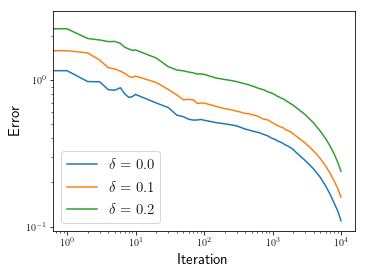

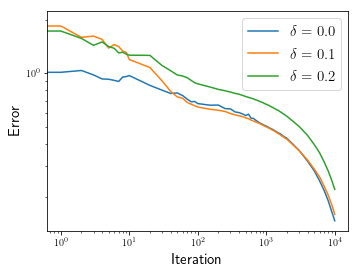

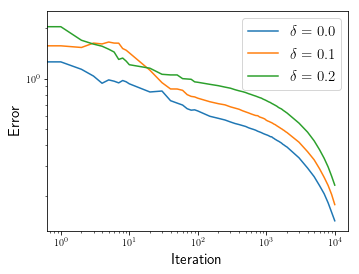

In [64]:
model_name = 'LR'
LR_res_table = pd.read_pickle('LR_converge_rate.pkl')
delta_size_list = [0.0,0.1,0.2]
sample_size_list = [64, 256, 1024]
for sample_size in sample_size_list:
    fig = plt.figure(figsize=(5.4, 5.4*0.75))
    for delta in delta_size_list:
        sub_res_table = LR_res_table[(LR_res_table.sample_size == sample_size) & (LR_res_table.delta == delta)]
        plt.loglog(sub_res_table.Iteration.values, sub_res_table.Error.values)
    plt.legend(["$\delta = 0.0$","$\delta = 0.1$","$\delta = 0.2$"],fontsize = 15)
    plt.xlabel("Iteration", fontsize = 15)
    plt.ylabel("Error", fontsize = 15)
    fig.savefig("convergence_rate_fig/{}_convergence_sample_size_{}.pdf".format(model_name, sample_size))

In [8]:
logistic_res_table_list = []
learning_rate = 0.3
loss_path_idx = list(range(10))+ list(range(10,100,10)) + \
list(range(100,2001,50)) + list(range(3000,10001,1000)) + [20000]
true_var = np.random.randn(32)
sample_size_list = [64, 256, 1024]
delta_size_list = [0.0,0.1,0.2]
for sample_size, delta in itertools.product(sample_size_list, delta_size_list):
    print('sample_size = {},\tdelta = {}'.format(sample_size, delta), end = '\t...\t')
    X, y = LogisticRegressionDataGenerator(true_var).generate(sample_size)
    my_DR_Logistic_model = DistRobustLogisticRegression(X=X, y=y)
    my_DR_Logistic_model.delta = delta
    my_DR_Logistic_model.learning_rate = learning_rate
    my_DR_Logistic_model.optimize(loss_path_idx = loss_path_idx)
    temp_res_table = pd.DataFrame({
        'Iteration': list(my_DR_Logistic_model.loss_path.keys())[:-1],
        'Error': np.squeeze(list(my_DR_Logistic_model.loss_path.values())[:-1] - \
                            list(my_DR_Logistic_model.loss_path.values())[-1]),
        'delta': delta,
        'sample_size': sample_size})
    logistic_res_table_list.append(temp_res_table)
    print('Done')
logistic_res_table = pd.concat(logistic_res_table_list).reset_index(drop = True)
logistic_res_table.to_pickle('logistic_converge_rate.pkl')

sample_size = 64,	delta = 0.0	...	Done
sample_size = 64,	delta = 0.1	...	Done
sample_size = 64,	delta = 0.2	...	Done
sample_size = 256,	delta = 0.0	...	Done
sample_size = 256,	delta = 0.1	...	Done
sample_size = 256,	delta = 0.2	...	Done
sample_size = 1024,	delta = 0.0	...	Done
sample_size = 1024,	delta = 0.1	...	Done
sample_size = 1024,	delta = 0.2	...	Done


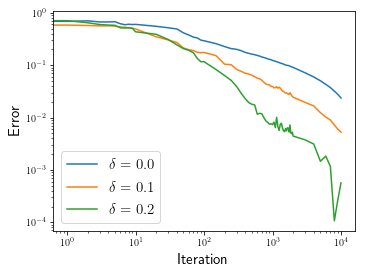

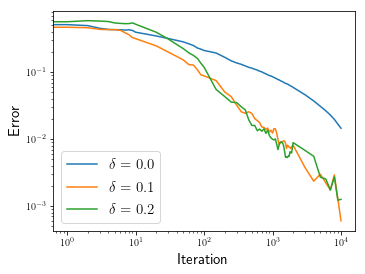

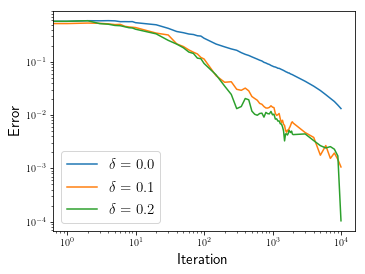

In [62]:
model_name = 'logistic'
delta_size_list = [0.0,0.1,0.2]
sample_size_list = [64, 256, 1024]
for sample_size in sample_size_list:
    fig = plt.figure(figsize=(5.4, 5.4*0.75))
    for delta in delta_size_list:
        sub_res_table = logistic_res_table[(logistic_res_table.sample_size == sample_size) 
                                           & (logistic_res_table.delta == delta)]
        plt.loglog(sub_res_table.Iteration.values, sub_res_table.Error.values)
    plt.legend(["$\delta = 0.0$","$\delta = 0.1$","$\delta = 0.2$"],fontsize = 15)
    plt.xlabel("Iteration", fontsize = 15)
    plt.ylabel("Error", fontsize = 15)
    fig.savefig("convergence_rate_fig/{}_convergence_sample_size_{}.pdf".format(model_name, sample_size))

In [49]:
SVM_res_table_list = []
learning_rate = 0.05
loss_path_idx = list(range(10))+ list(range(10,100,10)) + \
list(range(100,2001,50)) + list(range(3000,10001,1000)) + [20000]
true_var = np.random.randn(32)
sample_size_list = [64, 256, 1024]
delta_size_list = [0.0,0.1,0.2]
for sample_size, delta in itertools.product(sample_size_list, delta_size_list):
    print('sample_size = {},\tdelta = {}'.format(sample_size, delta), end = '\t...\t')
    X, y = LogisticRegressionDataGenerator(true_var).generate(sample_size)
    my_DR_SVM_model = DistRobustSVM(X=X, y=y)
    my_DR_SVM_model.delta = delta
    my_DR_SVM_model.learning_rate = learning_rate
    my_DR_SVM_model.optimize(loss_path_idx = loss_path_idx)
    temp_res_table = pd.DataFrame({
        'Iteration': list(my_DR_SVM_model.loss_path.keys())[:-1],
        'Error': np.squeeze(list(my_DR_SVM_model.loss_path.values())[:-1] - \
                            list(my_DR_SVM_model.loss_path.values())[-1]),
        'delta': delta,
        'sample_size': sample_size})
    SVM_res_table_list.append(temp_res_table)
    print('Done')
SVM_res_table = pd.concat(SVM_res_table_list).reset_index(drop = True)
SVM_res_table.to_pickle('SVM_converge_rate.pkl')

sample_size = 64,	delta = 0.0	...	Done
sample_size = 64,	delta = 0.1	...	Done
sample_size = 64,	delta = 0.2	...	Done
sample_size = 256,	delta = 0.0	...	Done
sample_size = 256,	delta = 0.1	...	Done
sample_size = 256,	delta = 0.2	...	Done
sample_size = 1024,	delta = 0.0	...	Done
sample_size = 1024,	delta = 0.1	...	Done
sample_size = 1024,	delta = 0.2	...	Done


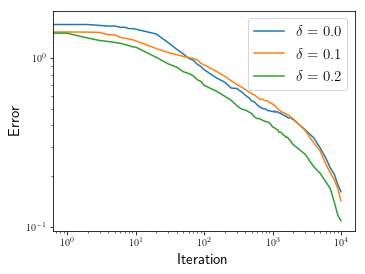

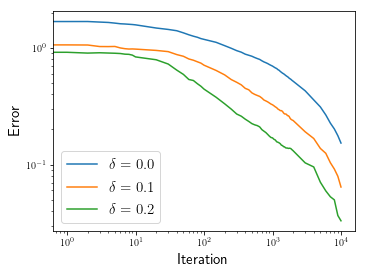

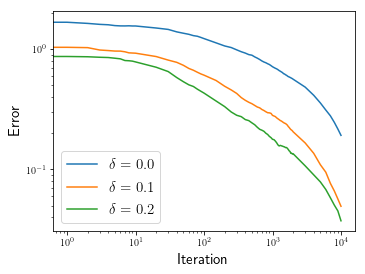

In [61]:
model_name = 'SVM'
delta_size_list = [0.0,0.1,0.2]
sample_size_list = [64, 256, 1024]
for sample_size in sample_size_list:
    fig = plt.figure(figsize=(5.4, 5.4*0.75))
    for delta in delta_size_list:
        sub_res_table = SVM_res_table[(SVM_res_table.sample_size == sample_size) 
                                           & (SVM_res_table.delta == delta)]
        plt.loglog(sub_res_table.Iteration.values, sub_res_table.Error.values)
    plt.legend(["$\delta = 0.0$","$\delta = 0.1$","$\delta = 0.2$"],fontsize = 15)
    plt.xlabel("Iteration", fontsize = 15)
    plt.ylabel("Error", fontsize = 15)
    #plt.ylim([0.05,5])
    fig.savefig("convergence_rate_fig/{}_convergence_sample_size_{}.pdf".format(model_name, sample_size))

In [65]:
np.random.seed(206)
true_var_w_dist = np.random.randn(2)
X_w_dist, y_w_dist = LogisticRegressionDataGenerator(true_var_w_dist).generate(64)

In [66]:
my_DR_Logistic_model_WD = DistRobustLogisticRegression(X=X_w_dist, y=y_w_dist)
my_DR_Logistic_model_WD.delta = 0
my_DR_Logistic_model_WD.optimize(loss_path_idx = [])
var_delta_0 = my_DR_Logistic_model_WD.var

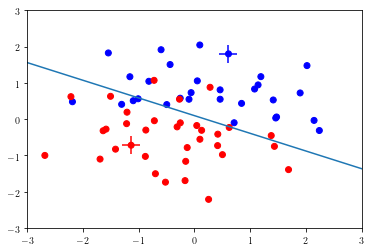

In [71]:
c = ["red" for _ in y_w_dist]
for idx, _ in enumerate(y_w_dist):
    if _ == 1:
        c[idx] = "blue"
red_marker_id = 5
blue_marker_id = 7
x_line = np.array([-3,3])
y_line = (- my_DR_Logistic_model_WD.var[0]*x_line - my_DR_Logistic_model_WD.var[2]) /my_DR_Logistic_model_WD.var[1]
plt.scatter(X_w_dist[:,0], X_w_dist[:,1], c = c)
plt.scatter(X_w_dist[red_marker_id,0], X_w_dist[red_marker_id,1], c = 'red', marker = "+", s = 300)
plt.scatter(X_w_dist[blue_marker_id,0], X_w_dist[blue_marker_id,1], c = 'blue', marker = "+", s = 300)
plt.plot(x_line,y_line)
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [67]:
a = []
for i in range(0,16,1):
    delta = 0.1 * i
    my_DR_Logistic_model_WD.var = var_delta_0
    my_DR_Logistic_model_WD.delta = delta
    a += [my_DR_Logistic_model_WD.compute_transport_X()]

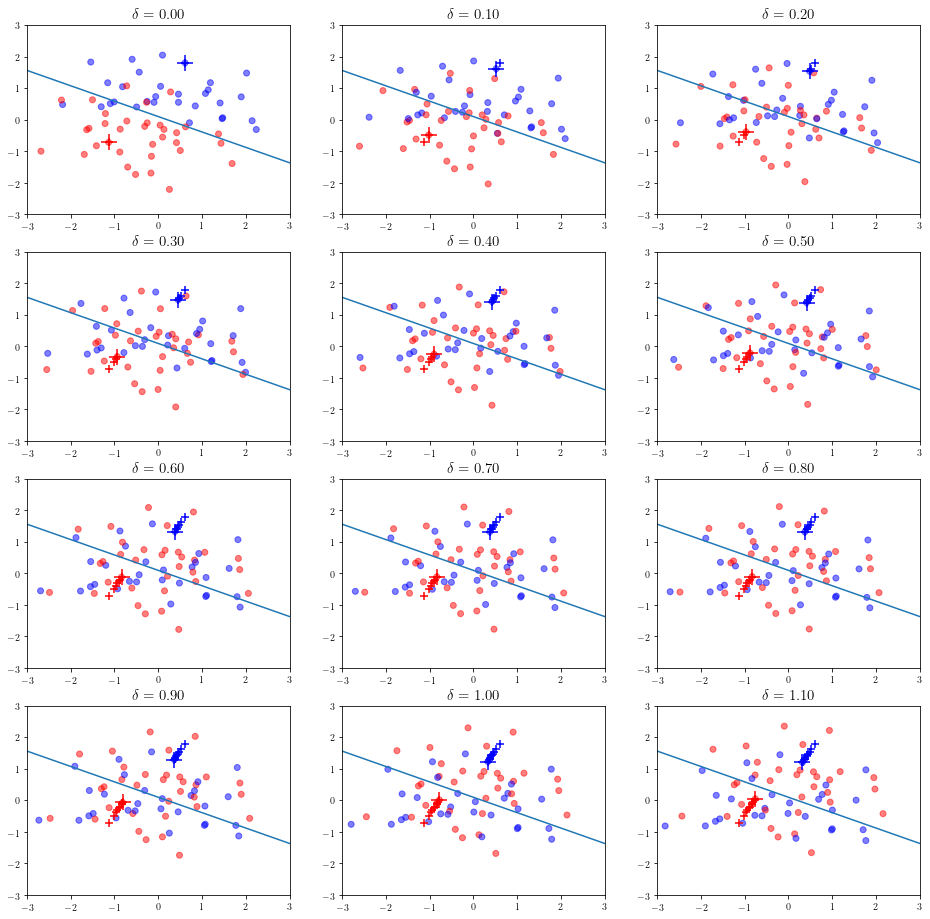

In [73]:
fig = plt.figure(figsize=(16,16))
for i in range(0,12,1):
    plt.subplot(4,3,i+1)
    plt.scatter(x = a[i][:,0], y = a[i][:,1],c=c, alpha = 0.5)
    
    red_path = np.vstack([a[j][red_marker_id,:] for j in range(i+1)])
    blue_path = np.vstack([a[j][blue_marker_id,:] for j in range(i+1)])
    plt.scatter(red_path[:,0], red_path[:,1], c = 'red', marker = "+", s = 50)
    plt.scatter(blue_path[:,0], blue_path[:,1], c = 'blue', marker = "+", s = 50)
    plt.scatter(a[i][red_marker_id,0], a[i][red_marker_id,1], c = 'red', marker = "+", s = 250)
    plt.scatter(a[i][blue_marker_id,0], a[i][blue_marker_id,1], c = 'blue', marker = "+", s = 250)
    plt.plot(x_line,y_line)
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.title("$\delta = {:.2f}$".format(0.1 * (i)), fontsize = 15)
fig.savefig("Worst_Dist.pdf")